In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices, SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_error

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0, 1.0]

In [2]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]

corr = -0.5
theta = [0., 0., corr]
model.copula_parameters = theta

In [13]:
Nv = 10000

n_tests = 20
min_Ni = 2
max_Ni = 30

min_No = 1
max_No = 30

n_boot = 1000
n_run = 50
all_Ni = np.random.randint(min_Ni, max_Ni, n_tests, dtype=int)
all_No = np.random.randint(min_Ni, max_Ni, n_tests, dtype=int)

In [14]:
ot.RandomGenerator.SetSeed(1)
np.random.seed(1)

all_shapley_results = np.zeros((n_tests, n_run, dim, n_boot))
all_first_results = np.zeros((n_tests, n_run, dim, n_boot))
all_total_results = np.zeros((n_tests, n_run, dim, n_boot))

for i_test, (Ni, No) in enumerate(zip(all_Ni, all_No)):
    print('Ni:', Ni, 'No:', No)
    for i_run in range(n_run):
        shapley = ShapleyIndices(model.input_distribution)
        shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
        shapley_results = shapley.compute_indices(n_boot=n_boot)
        all_shapley_results[i_test, i_run] = shapley_results.full_shapley_indices
        all_first_results[i_test, i_run] = shapley_results.full_first_indices
        all_total_results[i_test, i_run] = shapley_results.full_total_indices

Ni: 18 No: 22
Ni: 29 No: 24
Ni: 27 No: 10
Ni: 8 No: 20
Ni: 21 No: 27
Ni: 12 No: 26
Ni: 10 No: 12
Ni: 29 No: 11
Ni: 14 No: 27
Ni: 14 No: 18


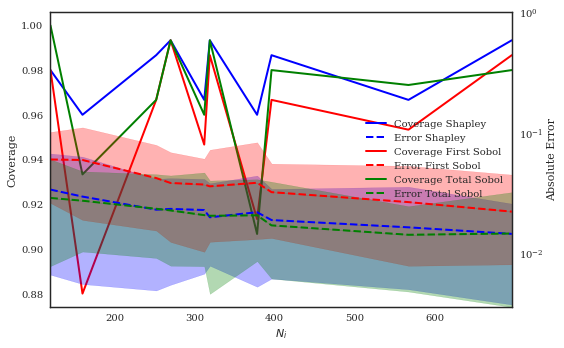

In [18]:
results = {
    'Shapley': all_shapley_results,
    'First Sobol': all_first_results,
    'Total Sobol': all_total_results
}

true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_order_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}
alpha = [2.75, 97.5]
fig, ax = plt.subplots(figsize=(8, 5))
plot_error(results, all_Ni*all_No, true_results, ax=ax, ylim=None, alpha=alpha, loc=5, logscale=True)
fig.tight_layout()

if savefigs:
    fig.savefig('./output/gaussian_precision_%d_rho_%.2f_Nv_%d_No_%d_maxNi_%d_nrun%d.pdf' % (len(results), corr, Nv, No, max_Ni, n_run))

In [30]:
def plot_std(results, x, ax=None, figsize=(7, 4), ylim=None, alpha=[2.5, 97.5], loc=0, logscale=False):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    colors = {
        'Shapley': 'b',
        'First Sobol': 'r',
        'Total Sobol': 'g'
    }
            
    sorted_x = np.argsort(x)
    for i, name in enumerate(results):
        result = results[name]
        true_indices = true_results[name]
        dim = true_indices.shape[0]
        no_boot_estimation = result[:, :, :, 0]
        quantiles = np.percentile(result[:, :, :, 1:], alpha, axis=3)
        std = result.std(axis=3).mean(axis=1)
        error_up = 2*no_boot_estimation - quantiles[0]
        error_down = 2*no_boot_estimation - quantiles[1]
        cover = ((error_down < true_indices.reshape(1, 1, dim)) & (error_up > true_indices.reshape(1, 1, dim))).mean(axis=1)
        error = (abs(no_boot_estimation - true_indices)).mean(axis=2)
        error_quants = np.percentile(error, [5, 95], axis=1)

        lns1 = ax.plot(x[sorted_x], std[sorted_x].mean(axis=1), '-', label='Coverage %s' % (name), linewidth=2, color=colors[name])

    ax.set_xlabel('$N_i$')
    ax.set_ylabel('Coverage')
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(ylim)

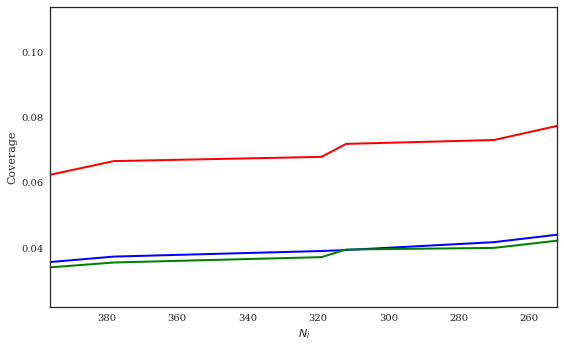

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_std(results, all_Ni*all_No, ax=ax, ylim=None, alpha=alpha, loc=5, logscale=True)
fig.tight_layout()